<a href="https://colab.research.google.com/github/adiogale/DGM/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your name:
Aditya Ogale

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

4431872/4422102 [==============================] - 0s 0us/step


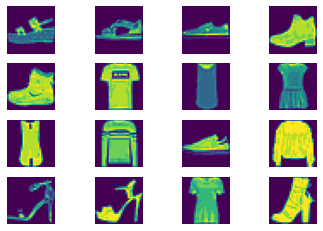

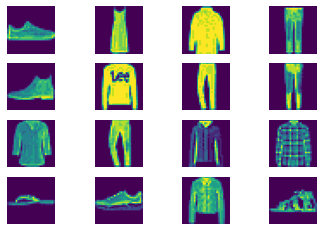

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
import tensorflow as tf

(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()
var_num = 784
xtrain = np.round(xtrain / 27).astype(int);
xtest = np.round(xtest / 27).astype(int);

xtrain_flat = np.reshape(xtrain, (-1,var_num))
xtest_flat = np.reshape(xtest, (-1,var_num)) 

train_size = xtrain_flat.shape[0]
test_size = xtest_flat.shape[0]
batch_size = 100
train_dataset = (tf.data.Dataset.from_tensor_slices(xtrain_flat).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(xtest_flat).shuffle(test_size).batch(batch_size))

def draw_grid(imlist, m, n):
  fig, grid = plt.subplots(m,n) 
  for i in range(m):
    for j in range(n):
      grid[i,j].axis('off')
      grid[i,j].imshow(np.reshape(imlist[(i-1)*m+j], (28,28)))

draw_grid(xtrain[:16], 4,4)
draw_grid(xtest[:16],4,4)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as ag
from torch.nn import functional as F
from torch.distributions.categorical import Categorical

class NADE(nn.Module):
  def __init__(self, batch_size, input_size, h_size, device, class_no = 10):
    super(NADE, self).__init__()

    self.batch_size = batch_size
    self.input_size = input_size
    self.h_size = h_size
    self.device = device
    self.class_no = class_no
    
    # W = 784 X 500 X 10
    self.W = torch.nn.Parameter(torch.randn(self.input_size, self.h_size, self.class_no, device=device, requires_grad=True))
    # b = 500 X 10
    self.b = torch.nn.Parameter(torch.randn(self.h_size, self.class_no, device=device, requires_grad=True))

    # V = 10 X 500 X 784
    self.V = torch.nn.Parameter(torch.randn(self.class_no, self.h_size, self.input_size, device=device, requires_grad=True))
    # c = 784
    self.c = torch.nn.Parameter(torch.randn(self.input_size, device=device, requires_grad=True))

  def forward(self, data):
    # Returns probability matrix of all images in a batch with dim [batch_size, 784, 10], data in one_hot encoding with dim [batch_size, 784, 10], W and V matrices.
    px = []
    data = torch.nn.functional.one_hot(data, num_classes=10).type(torch.FloatTensor)

    # a = 10 X 100 X 500
    a = torch.stack(self.batch_size * [self.b]).to(self.device)
    a = a.permute(2,0,1)
    
    for pxl_idx in range(self.input_size):
      # h = 10 X 100 X 500
      h = torch.sigmoid(a)

      # px_img = 100 X 10
      px_img = torch.log_softmax(h.bmm(self.V[:, :, pxl_idx:pxl_idx+1])+self.c[pxl_idx:pxl_idx+1], dim = 0).squeeze(dim=2).t()

      # x = 10 X 100 X 1
      x = data[:, pxl_idx:pxl_idx+1, :].permute(2,0,1).to(self.device)
      # w = 10 X 1 X 500
      w = self.W[pxl_idx:pxl_idx+1, :, :].permute(2,0,1).to(self.device)

      # a = 10 X 100 X 500
      a = torch.add(a, x.bmm(w))

      px.append(px_img)
    px = torch.stack(px, dim=1)
    return px


  def sample(self):
    a = self.b
    img = []
    output=[]
    for i in range(self.input_size):
      h = torch.sigmoid(a.t()).reshape(self.class_no, 1, self.h_size)
      px_img = torch.log_softmax(h.bmm(self.V[:, :, i:i+1])+self.c[i:i+1], dim = 0).squeeze(1).squeeze(1)
      p_pred = Categorical(logits=px_img).sample()
      output.append(p_pred)
      w = self.W[i:i+1, :, :].permute(2,1,0).to(self.device)
      x = torch.nn.functional.one_hot(p_pred, num_classes=10).unsqueeze(dim=1).unsqueeze(dim=1).type(torch.FloatTensor).to(self.device)
      a = torch.add(a, w.bmm(x).squeeze(2).t())
    return torch.tensor(output)



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NADE(batch_size, 784, 500, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
epochs = 6

def train(model, loss_fn, optimizer, train_dataset,device):
    sum_loss = 0
    for batch, data in enumerate(train_dataset):
      data = torch.tensor(data.numpy(), device=device)
      optimizer.zero_grad()

      pred = model(data)

      loss = loss_fn(pred, data)
      sum_loss += loss.item()
      loss.backward()
      optimizer.step()
      
      if batch % 100 == 0 and batch!=0:
        print("loss: ", loss.item(), " for batch: ", batch, " of ", batch_size, " images with avg loss of ", sum_loss/batch)
    test_loss = calc_test_loss(model)
    return model, sum_loss/(60000/batch_size), test_loss/100


def calc_test_loss(model):
  sum_loss = 0
  for batch, data in enumerate(test_dataset):
    data = torch.tensor(data.numpy(), device=device)
    pred = model(data)
    sum_loss += loss_fn(pred, data).item()
  return sum_loss


def loss_fn(pred, input):
  loss = torch.nn.NLLLoss(reduction = "sum")
  #(100, 10, 784), (100, 784)
  return loss(pred.permute(0,2,1),input)/batch_size

for i in range(epochs):
  model, loss, test_loss = train(model, loss_fn, optimizer, train_dataset, device)
  print("Epoch ", i+1, " completed with training loss ", loss, " and test loss ", test_loss)

loss:  824.9412841796875  for batch:  100  of  100  images with avg loss of  2377.4336895751953
loss:  749.4863891601562  for batch:  200  of  100  images with avg loss of  1561.8368112182618
loss:  692.927490234375  for batch:  300  of  100  images with avg loss of  1273.0364188639323
loss:  712.0823364257812  for batch:  400  of  100  images with avg loss of  1123.9208625793458
loss:  690.5778198242188  for batch:  500  of  100  images with avg loss of  1033.807711669922
Epoch  1  completed with training loss  971.0465226236979  and test loss  664.1497540283203
loss:  655.9679565429688  for batch:  100  of  100  images with avg loss of  655.3019256591797
loss:  649.955078125  for batch:  200  of  100  images with avg loss of  650.2150604248047
loss:  631.0692138671875  for batch:  300  of  100  images with avg loss of  650.7055828857422
loss:  648.892333984375  for batch:  400  of  100  images with avg loss of  650.1259936523437
loss:  639.7006225585938  for batch:  500  of  100  ima

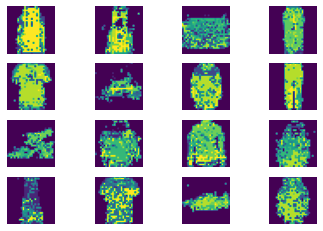

In [ ]:
outputs = []
for i in range(16):
  output = model.sample().reshape(28,28)
  outputs.append(output)

m=4
n=4
fig, grid = plt.subplots(m,n) 
for i in range(m):
  for j in range(n):
    grid[i,j].axis('off')
    grid[i,j].imshow(np.reshape(outputs[(i-1)*m+j], (28,28)))

In [ ]:
torch.save(model, "NADE saved last")

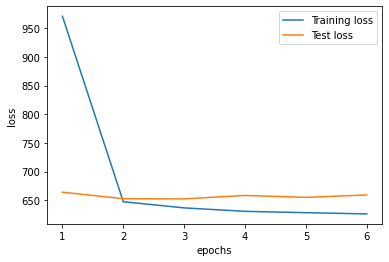

In [ ]:
train_loss = [971.0465226236979, 647.5423759969076, 636.8088392130534, 630.7690213012695, 628.4531216430664, 626.2815819295247]
test_loss = [664.1497540283203, 652.8202630615234, 652.4980462646485, 658.5062927246094, 655.1623706054687, 659.3652917480468]

import numpy
x_axis = numpy.arange(1,7)
y_axis = numpy.arange(0,800)

plt.plot(x_axis, train_loss, label = "Training loss")
plt.plot(x_axis, test_loss, label = "Test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


In [ ]:
print(sum(train_loss)/len(train_loss))
print(sum(test_loss)/len(test_loss))

690.1502437845866
657.0836697387696
